# Problem Set #7

### MACS 30150, Dr. Evans
### Ruixi Li

In [16]:
import warnings
warnings.filterwarnings("ignore")

## 1.Decision trees

In [17]:
import numpy as np
import pandas as pd

df = pd.read_csv('biden.csv')
df = df.dropna()
print(df.head())

   biden  female  age  educ  dem  rep
0     90       0   19    12    1    0
1     70       1   51    14    1    0
2     60       0   27    14    0    0
3     50       1   43    14    1    0
4     60       1   38    14    0    1


#### (a) Split the data into a training set (70%) and a test set (30%)


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

y = df["biden"].values
X = df[["female", "age", "dem", "rep", "educ"]].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=25)

biden_tree = DecisionTreeRegressor(max_depth=3, min_samples_leaf=5)
biden_tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

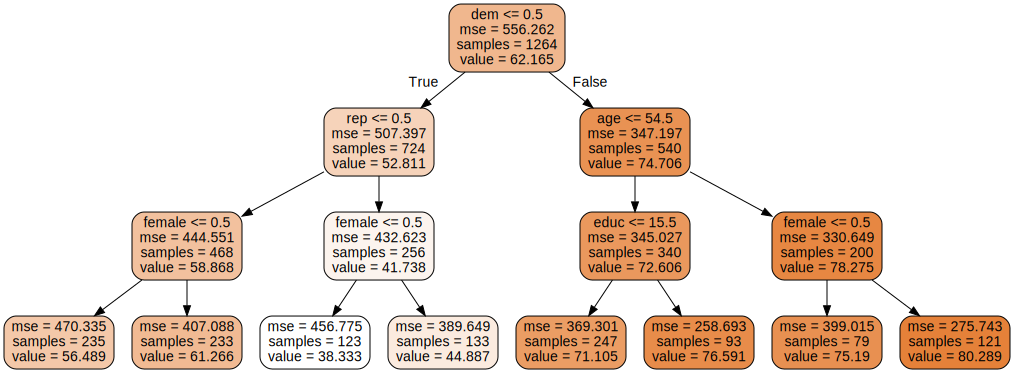

In [19]:
from sklearn.tree import export_graphviz
import graphviz

biden_tree_viz = export_graphviz(
    biden_tree,
    out_file=None,
    feature_names=["female", "age", "dem", "rep", "educ"],
    class_names=df["biden"],
    rounded=True,
    filled=True,
)

graph = graphviz.Source(biden_tree_viz)
graph.render('biden_tree_viz')
graph

The binary decision tree splits the predictors into eight terminals. The first node is `dem`. The left-hand branch of it is `rep` which is splited by rep, while the right-hand branch of it is `dem` which is splited by age. The four nodes below them are splited by female, female, educ, and female, respectively. In the bottom, each node represent a partition of feature space. 

From the result, we could see that Democrats tend to give Joe Biden warmer feelings than non-Democrats. Among Non-Democrats, the respondents who are not Republicans tend to have warmer feeling for Joe Biden than the Non-Democrats who are Republicans. Female democrats, who are older than 54.5 years old give Joe Biden highest `biden`, while those who are non-Democrats, Republicans, and male give Joe Biden least `biden`. Democrats, who are less than 54.5 years old and at least 15.5 years of education has the least mse, while Non-Democrats, Non-Republicans and male has the largest mse.

In [20]:
from sklearn.metrics import mean_squared_error

y_pred = biden_tree.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)
print('The test MSE is ', MSE)

The test MSE is  396.1937146321307


#### (b) Use sklearn.model selection.RandomizedSearchCV to optimally tune the hyperparameters in the decision tree from part (a).

In [21]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

param_dist1 = {'max_depth': [3, 10],
               'min_samples_split': sp_randint(2, 20),
               'min_samples_leaf': sp_randint(2, 20)}

random_search1 = \
    RandomizedSearchCV(biden_tree, param_distributions=param_dist1,
                       n_iter=100, n_jobs=-1, cv=5, random_state=25,
                       scoring='neg_mean_squared_error')

random_search1.fit(X_train, y_train)
print('The optimal tuning parameter values are', random_search1.best_params_)
print('The MSE of the optimal results is', -random_search1.best_score_)

The optimal tuning parameter values are {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 9}
The MSE of the optimal results is 404.7488359884144


The optimal MSE is 404.75 when max_depth is 3, min_sample_leaf is 2, and min_sample_split is 9.

#### (c) Now tune the parameters of a RandomForest regression model on these data sklearn.ensemble.RandomForestRegressor(). 

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

random_forest = RandomForestRegressor()

sel = SelectFromModel(RandomForestRegressor(n_estimators = 100))
sel.fit(X_train, y_train)
sel.get_support()

array([False,  True, False, False, False])

In [26]:
X = df[["female", "age", "dem", "rep", "educ"]].values


AttributeError: 'numpy.ndarray' object has no attribute 'head'

The optimal MSE is 398.14 when max_depth is 3, max_features is 3, min_sample_leaf is 18, min_sample_split is 6 and n_estimators is 200.

## 2. Classifier “horse” race

In [4]:
df2 = pd.read_csv('Auto.csv', na_values='?')
df2.columns = ['mpg', 'cyl', 'displ', 'hpwr', 'wgt', 'accl', 'yr', 'orgn','name']
df2['mpg_high'] = (df2['mpg']>=df2['mpg'].median()).astype('int')
df2.dropna(inplace=True)
df2.describe()

,mpg,cyl,displ,hpwr,wgt,accl,yr,orgn,mpg_high
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531,0.500000
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518,0.500639
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000,0.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000,0.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000,0.500000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000,1.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000,1.000000


#### (a) Use sklearn.linear model.LogisticRegression to fit a logistic model

In [5]:
df2_orgn = pd.get_dummies(df2.orgn, prefix='orgn').iloc[:, :-1]
df2 = pd.concat([df2, df2_orgn], axis=1)
df2.drop(['name'], axis=1, inplace=True)
df2.head()

,mpg,cyl,displ,hpwr,wgt,accl,yr,orgn,mpg_high,orgn_1,orgn_2
0,18.0,8,307.0,130.0,3504,12.0,70,1,0,1,0
1,15.0,8,350.0,165.0,3693,11.5,70,1,0,1,0
2,18.0,8,318.0,150.0,3436,11.0,70,1,0,1,0
3,16.0,8,304.0,150.0,3433,12.0,70,1,0,1,0
4,17.0,8,302.0,140.0,3449,10.5,70,1,0,1,0


In [6]:
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold
from sklearn.metrics import classification_report

df2["const"] = 1
X = df2[['const', 'cyl', 'displ', 'hpwr', 'wgt', 'accl', 'yr', 'orgn_1', 'orgn_2']].values
y = df2["mpg_high"].values

kf = KFold(n_splits=4, shuffle=True, random_state=25)
kf.get_n_splits(X)
MSE_vec_kf = np.zeros(4)
y_test_lst2 = np.zeros(df2.shape[0])
y_pred_lst2 = np.zeros(df2.shape[0])

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold
from sklearn.metrics import classification_report

df2["const"] = 1
X = df2[['const', 'cyl', 'displ', 'hpwr', 'wgt', 'accl', 'yr', 'orgn_1', 'orgn_2']].values
y = df2["mpg_high"].values

kf = KFold(n_splits=4, shuffle=True, random_state=25)
kf.get_n_splits(X)
MSE_vec_kf = np.zeros(4)
y_test_lst2 = np.zeros(df2.shape[0])
y_pred_lst2 = np.zeros(df2.shape[0])
k_ind = int(0)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    y_test_lst2[test_index] = y_test
    y_pred_lst2[test_index] = y_pred
    MSE_vec_kf[k_ind] = (y_test != y_pred).mean()
    k_ind += 1

MSE_kf = MSE_vec_kf.mean()
print('The MSE of the model is:', MSE_kf)
print(classification_report(y_test_lst2, y_pred_lst2))

The MSE of the model is: 0.09693877551020408
              precision    recall  f1-score   support

         0.0       0.92      0.89      0.90       196
         1.0       0.89      0.92      0.90       196

   micro avg       0.90      0.90      0.90       392
   macro avg       0.90      0.90      0.90       392
weighted avg       0.90      0.90      0.90       392



/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The average MSE of the model is 0.094. The error rate for mpg_high=0 is 0.08, and the error rate for mpg_high=1 is 0.11.

#### (b) Use sklearn.ensemble.RandomForestClassifier to fit a random forest model of mpg high on the eight possible features used in part (a).

In [11]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

random_forest2 = RandomForestClassifier()

param_dist3 = {'n_estimators':[10, 200],
               'max_depth': [3, 8],
               'min_samples_split': sp_randint(2, 20),
               'min_samples_leaf': sp_randint(2, 20),
               'max_features':sp_randint(1, 8)}

random_search3 = RandomizedSearchCV(random_forest2, param_distributions=param_dist3,
                                    n_iter=100, n_jobs=-1, cv=4, random_state=25,
                                    scoring='neg_mean_squared_error')

random_search3.fit(X, y)
print('The optimal tuning parameter values are', random_search3.best_params_)
print('The MSE of the optimal results is', -random_search3.best_score_)

The optimal tuning parameter values are {'max_depth': 8, 'max_features': 5, 'min_samples_leaf': 16, 'min_samples_split': 10, 'n_estimators': 10}
The MSE of the optimal results is 0.08163265306122448


MSE is 0.0893 when max_depth is 3, max_features is 4, min_sample_leaf is 13, min_sample_split is 7 and n_estimators is 10.

In [15]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from scipy.stats import randint as sp_randint
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)
sel.get_support()

array([False,  True,  True,  True,  True, False, False, False, False])

#### (c) Use sklearn.svm.SVC to fit a support vector machines model of mpg high with a Gaussian radial basis function kernel kernel=’rbf’ on the eight features used in parts (a) and (b).

In [13]:
from sklearn.svm import SVC
from scipy.stats import uniform as sp_uniform

param_dist4 = {'C': sp_uniform(loc=0.2, scale=4.0),
               'gamma': ['scale', 'auto'],
               'shrinking': [True, False]}

svc = SVC(kernel='rbf')
random_search4 = RandomizedSearchCV(svc, param_distributions=param_dist4,
                                    n_iter=100, n_jobs=-1, cv=4, random_state=25,
                                    scoring='neg_mean_squared_error')

rs_fit4 = random_search4.fit(X, y)
print('The optimal tuning parameter values are', random_search4.best_params_)
print('The MSE of the optimal results is', -random_search4.best_score_)

The optimal tuning parameter values are {'C': 1.1775180640974197, 'gamma': 'scale', 'shrinking': False}
The MSE of the optimal results is 0.11734693877551021


MSE is 0.12 when C is 1.18, gamma is scale and shrinking is False.

#### d. Conclusion

Random forest is the best model for predicting the mpg, because it has the lowest mse which is 0.0893.